## Trabajo final para la materia Vision Por Computadora 3 - Food Ingredients
Clasificación de ingredientes de cocina: Entrenar un modelo ViT que, a partir de imágenes, clasifique distintos tipos de ingredientes utilizados en la cocina


Grupo: 
  - Martin Brocca
  - Ariadna Garmendia
  - Carina Roldan

## 1 Análisis Exploratorio de Datos

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
import math
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import cv2
import imagehash

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T

#from umap.umap_ import UMAP

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.metrics import precision_recall_fscore_support

### 1.1 Config y utilidades

In [24]:
# ==== CONFIG ====
# Configuración de rutas
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data/raw'
SEED = 42
IMG_SIZE_STATS = (256, 256)   # para thumbnails de stats/preview
EMBED_IMG_SIZE = 224          # tamaño para embeddings ResNet
N_SAMPLES_PREVIEW = 2         # previews por clase

random.seed(SEED)
np.random.seed(SEED)

# ==== Helpers ====
def list_images_by_class(root_dir):
    """Lista todas las imágenes en subdirectorios de root_dir y devuelve un DataFrame con las rutas y clases."""
    root = Path(root_dir)
    print(f"Listando imágenes en {root_dir}...")
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    items = []
    for cls in classes:
        for fp in (root/cls).glob("*.*"):
            if fp.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}:
                items.append({"path": str(fp), "class": cls})
    return pd.DataFrame(items)

def load_image(path, to_rgb=True):
    img = Image.open(path)
    if to_rgb and img.mode != "RGB":
        img = img.convert("RGB")
    return img

def show_grid(images, titles=None, cols=4, figsize=(10,8)):
    rows = math.ceil(len(images)/cols)
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im)
        if titles:
            plt.title(titles[i], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### 1.2 Tabla resumen por clase (conteo, % y pesos sugeridos)

In [13]:
# Configuración de rutas
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data/raw'
# verificar la existencia del dataset
train_dataset_path = DATA_DIR / 'huggingface/Train'
val_dataset_path = DATA_DIR / 'huggingface/val'
if not train_dataset_path.exists():
    raise FileNotFoundError(f"El dataset no se encuentra en la ruta: {train_dataset_path}")
elif not val_dataset_path.exists():
    raise FileNotFoundError(f"El dataset no se encuentra en la ruta: {val_dataset_path}")
# listar las carpetas de clases
train_class_folders = [f.name for f in train_dataset_path.iterdir() if f.is_dir()]
print(f"Clases encontradas: {train_class_folders}") 
val_class_folders = [f.name for f in val_dataset_path.iterdir() if f.is_dir()]
print(f"Clases encontradas: {val_class_folders}") 
#total de clases encontradas:
print(f"Total de clases encontradas: {len(train_class_folders)}")
# verificar que las clases en entrenamiento y validación coincidan
if len(train_class_folders) != len(val_class_folders):
    raise ValueError("Las clases en el conjunto de entrenamiento y validación no coinciden.")  


# contar la cantidad de archivos por clase en el conjunto de entrenamiento
train_file_counts = {cls: len(list((train_dataset_path / cls).glob('*'))) for cls in train_class_folders}
val_file_counts = {cls: len(list((val_dataset_path / cls).glob('*'))) for cls in train_class_folders}


# Armar una tabla pivot resumen con la cantidad de archivos por clase y el conjunto al que pertenecen
# Crear un DataFrame con los conteos
data = []
for cls in train_class_folders:
    data.append({'Clase': cls, 'Conjunto': 'Entrenamiento', 'Cantidad de Archivos': train_file_counts[cls]})
    data.append({'Clase': cls, 'Conjunto': 'Validación', 'Cantidad de Archivos': val_file_counts[cls]})
df_counts = pd.DataFrame(data)
# Pivotar la tabla
pivot_table = df_counts.pivot(index='Clase', columns='Conjunto', values='Cantidad de Archivos').reset_index()
print("\nResumen de cantidad de archivos por clase y conjunto:")
print(pivot_table) 

Clases encontradas: ['Chilli pepper', 'Broccoli', 'Jalepeno', 'Beetroot', 'Mango', 'Pomegranate', 'Spinach', 'Turnip', 'Onion', 'Strawberry', 'Banana', 'Sweetpotato', 'Dragon_fruit', 'Bottle Gourd', 'Cucumber', 'Sweetcorn', 'Pear', 'Pineapple', 'Blueberry', 'Okra', 'Garlic', 'Potato', 'Sponge Gourd', 'Cantaloupe', 'Cabbage', 'Spiny Gourd', 'Fig', 'Pumpkin', 'Raddish', 'Bell pepper', 'Apple', 'Eggplant', 'Amaranth', 'Peas', 'Raspberry', 'Paprika', 'Ridge Gourd', 'Carrot', 'Lemon', 'Soy beans', 'Cauliflower', 'Capsicum', 'Watermelon', 'Tomato', 'Coconut', 'Ginger', 'Bitter Gourd', 'Corn', 'Orange', 'Grapes', 'Kiwi']
Clases encontradas: ['Chilli pepper', 'Broccoli', 'Jalepeno', 'Beetroot', 'Mango', 'Pomegranate', 'Spinach', 'Turnip', 'Onion', 'Strawberry', 'Banana', 'Sweetpotato', 'Bottle Gourd', 'Cucumber', 'Sweetcorn', 'Pear', 'Pineapple', 'Blueberry', 'Okra', 'Garlic', 'Potato', 'Sponge Gourd', 'Cantaloupe', 'Cabbage', 'Fig', 'Pumpkin', 'Raddish', 'Bell pepper', 'Apple', 'Eggplant', 'A

In [14]:
# análisis de datos, cantidad de clases y cantidad de imágenes por clase
#contar la cantidad de archivos en cada carpeta
classes = os.listdir(train_dataset_path)
class_counts = {}
for cls in classes:
    class_path = os.path.join(train_dataset_path, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))
print(class_counts)

{'Chilli pepper': 87, 'Broccoli': 80, 'Jalepeno': 88, 'Beetroot': 88, 'Mango': 86, 'Pomegranate': 79, 'Spinach': 97, 'Turnip': 98, 'Onion': 94, 'Strawberry': 82, 'Banana': 75, 'Sweetpotato': 69, 'Dragon_fruit': 64, 'Bottle Gourd': 80, 'Cucumber': 94, 'Sweetcorn': 91, 'Pear': 89, 'Pineapple': 99, 'Blueberry': 40, 'Okra': 32, 'Garlic': 92, 'Potato': 77, 'Sponge Gourd': 64, 'Cantaloupe': 30, 'Cabbage': 92, 'Spiny Gourd': 45, 'Fig': 28, 'Pumpkin': 80, 'Raddish': 81, 'Bell pepper': 90, 'Apple': 68, 'Eggplant': 84, 'Amaranth': 51, 'Peas': 100, 'Raspberry': 87, 'Paprika': 83, 'Ridge Gourd': 96, 'Carrot': 82, 'Lemon': 82, 'Soy beans': 97, 'Cauliflower': 79, 'Capsicum': 89, 'Watermelon': 84, 'Tomato': 92, 'Coconut': 34, 'Ginger': 68, 'Bitter Gourd': 80, 'Corn': 87, 'Orange': 68, 'Grapes': 100, 'Kiwi': 88}


### 1.3 Histograma de distribución por clase

Listando imágenes en /home/martin/Documents/CEIA/CEIA-VPC3/data/raw/huggingface/Train...
Listando imágenes en /home/martin/Documents/CEIA/CEIA-VPC3/data/raw/huggingface/val...


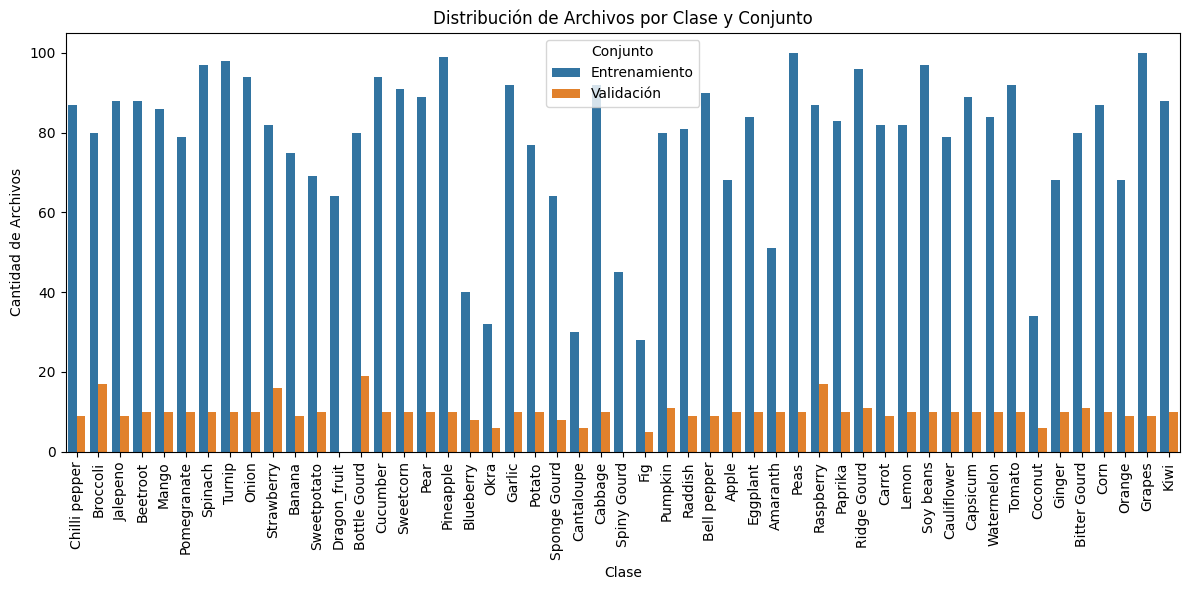

Ratio mayor/minor: 3
            class  count   pct  class_weight_suggested
0        Amaranth     51  1.28                   1.534
1           Apple     68  1.70                   1.151
2          Banana     75  1.88                   1.043
3        Beetroot     88  2.21                   0.889
4     Bell pepper     90  2.26                   0.869
5    Bitter Gourd     80  2.01                   0.978
6       Blueberry     40  1.00                   1.956
7    Bottle Gourd     80  2.01                   0.978
8        Broccoli     80  2.01                   0.978
9         Cabbage     92  2.31                   0.850
10     Cantaloupe     30  0.75                   2.608
11       Capsicum     89  2.23                   0.879
12         Carrot     82  2.06                   0.954
13    Cauliflower     79  1.98                   0.990
14  Chilli pepper     87  2.18                   0.899
15        Coconut     34  0.85                   2.301
16           Corn     87  2.18              

In [20]:
# mostrar algunas imágenes de ejemplo
df_train = list_images_by_class(train_dataset_path)
df_val = list_images_by_class(val_dataset_path)
assert len(df_train)>0, f"No se encontraron imágenes en {train_dataset_path}"
assert len(df_val)>0, f"No se encontraron imágenes en {val_dataset_path}"

class_counts = df_train['class'].value_counts().sort_index()
summary = pd.DataFrame({
    "class": class_counts.index,
    "count": class_counts.values
})
summary["pct"] = (summary["count"] / summary["count"].sum() * 100).round(2)
# pesos sugeridos: inversamente proporcionales a la frecuencia
summary["class_weight_suggested"] = (summary["count"].sum() / (len(summary)*summary["count"])).round(3)


plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x='Clase', y='Cantidad de Archivos', hue='Conjunto')
plt.title('Distribución de Archivos por Clase y Conjunto')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(BASE_DIR / 'outputs/figures/class_distribution.png')
plt.show()

print("Ratio mayor/minor:", int(summary["count"].max()/summary["count"].min()))
print(summary)


Se observa un claro desbalance de clases, con "trash" siendo la clase minoritaria


### 1.4 Previews por clase (muestras visuales)

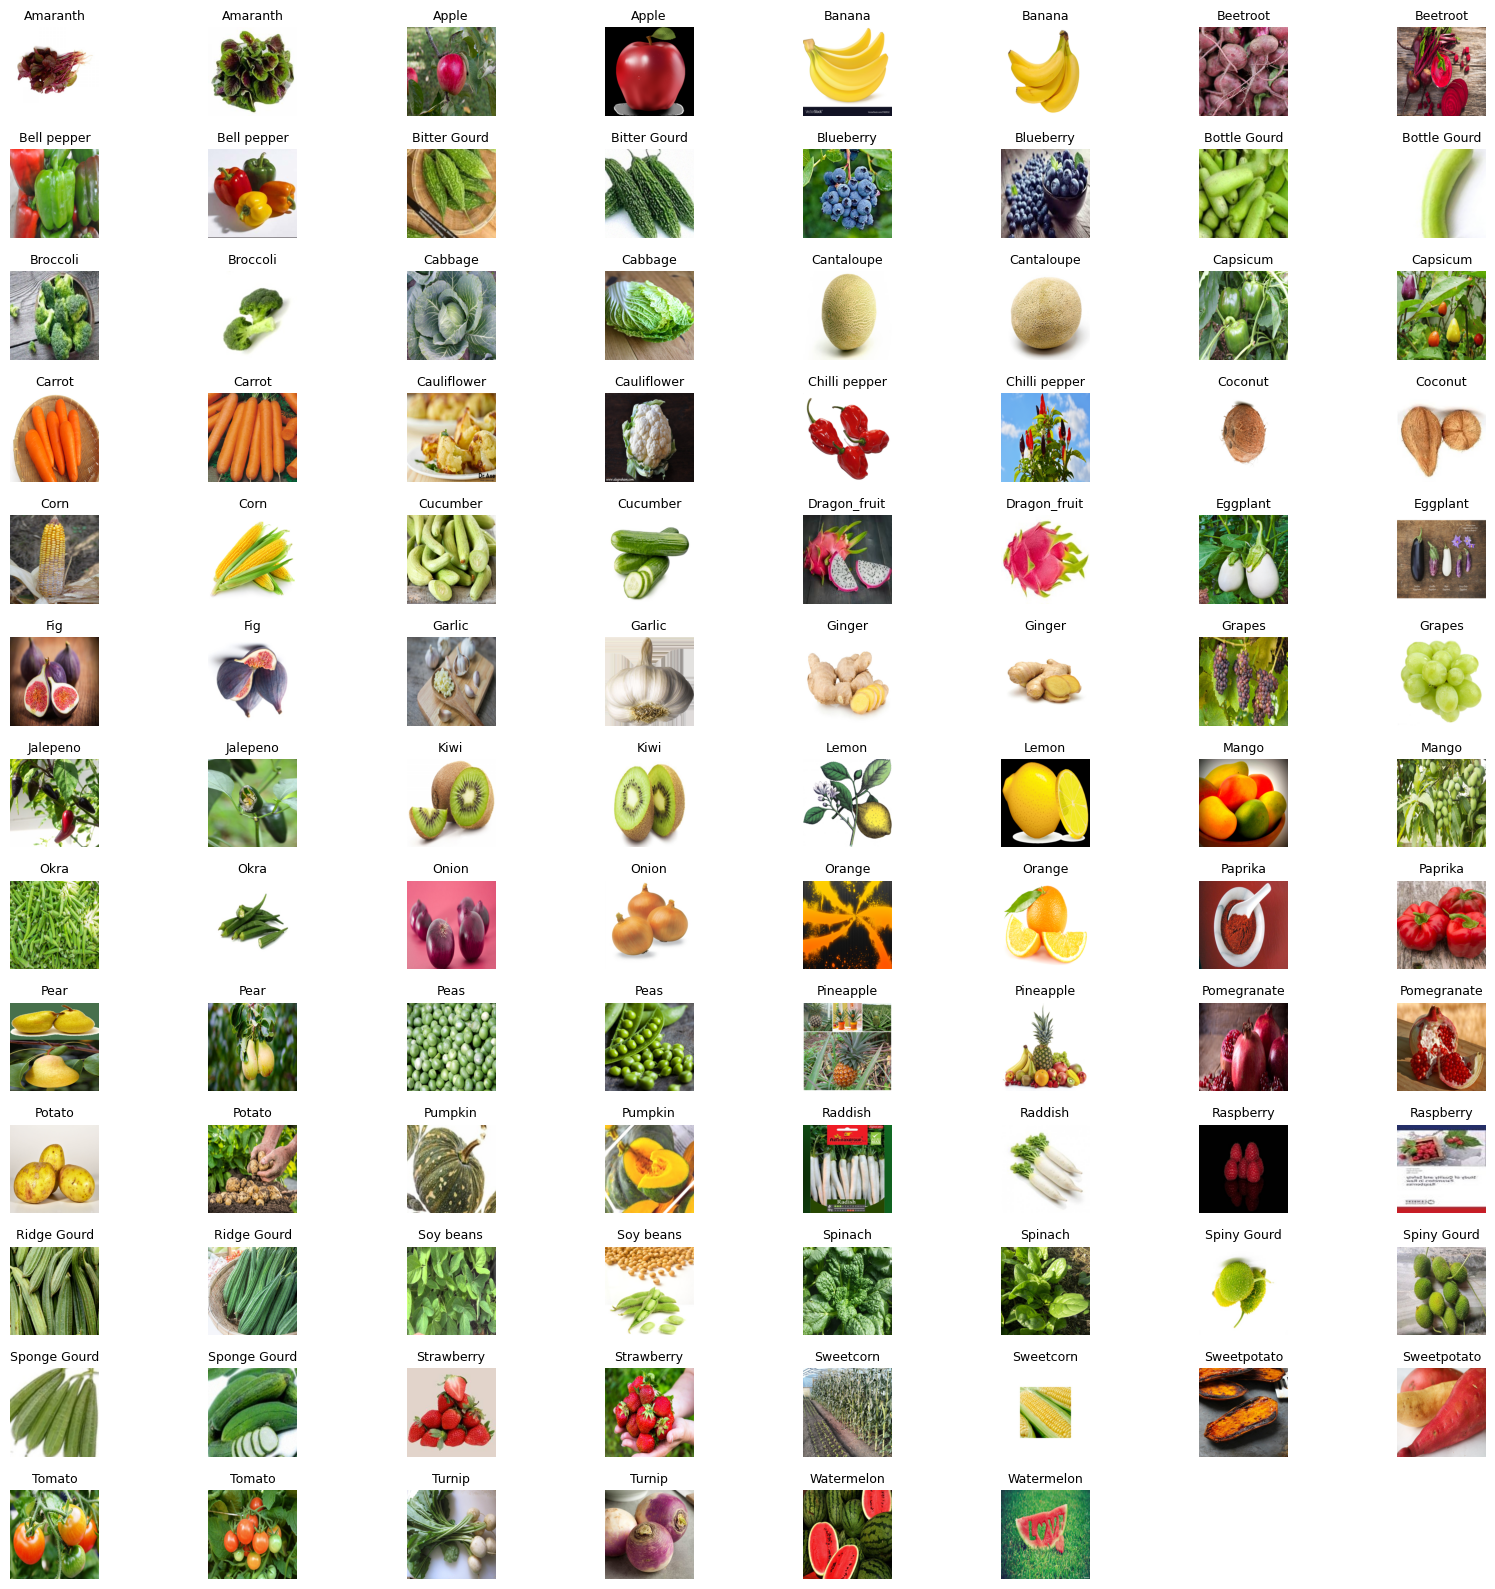

In [26]:
images, titles = [], []
for cls in summary["class"]:
    paths = df_train[df_train["class"]==cls]["path"].tolist()
    sample = random.sample(paths, k=min(N_SAMPLES_PREVIEW, len(paths)))
    for p in sample:
        img = load_image(p, to_rgb=True).resize(IMG_SIZE_STATS)
        images.append(img)
        titles.append(cls)

show_grid(images, titles, cols=8, figsize=(16, 16))

### 1.5 Tamaños / canales / aspecto

Leyendo metadata: 100%|██████████| 511/511 [00:00<00:00, 42184.92it/s]


Tamaño promedio Train (w,h): (1106.5, 919.1)
Tamaño promedio Val   (w,h): (1279.8, 1058.1)

 Resumen de modos por split:
mode   CMYK   P   RGB  RGBA
split                      
train     5  24  3813   148
val       1   0   502     8


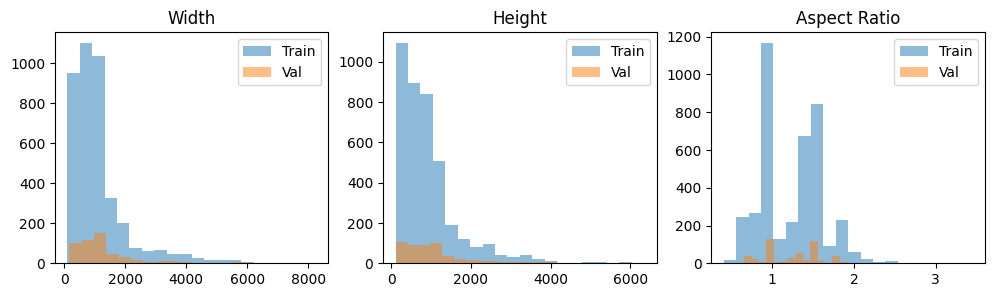

In [40]:
# Tamaños / canales / aspecto
train_sizes = []
train_modes = []
val_sizes = []
val_modes = []
#Train:
for p in tqdm(df_train["path"], desc="Leyendo metadata"):
    with Image.open(p) as im:
        train_sizes.append(im.size)   # (width, height)
        train_modes.append(im.mode)
#Val:
for p in tqdm(df_val["path"], desc="Leyendo metadata"):
    with Image.open(p) as im:
        val_sizes.append(im.size)   # (width, height)
        val_modes.append(im.mode)

train_sizes = np.array(train_sizes)
w_train, h_train = train_sizes[:,0], train_sizes[:,1]
val_sizes = np.array(val_sizes)
w_val, h_val = val_sizes[:,0], val_sizes[:,1]
train_aspect = w_train / h_train
val_aspect = w_val / h_val

df_meta_train = pd.DataFrame({
    "width": w_train,
    "height": h_train,
    "aspect": train_aspect,
    "mode": train_modes,
    "class": df_train["class"].values,
    "split": "train"
})

df_meta_val = pd.DataFrame({
    "width": w_val,
    "height": h_val,
    "aspect": val_aspect,
    "mode": val_modes,
    "class": df_val["class"].values,
    "split": "val"
})

meta = pd.concat([df_meta_train, df_meta_val], ignore_index=True)

mean_train_w = float(meta.loc[meta["split"] == "train", "width"].mean())
mean_train_h = float(meta.loc[meta["split"] == "train", "height"].mean())
mean_val_w   = float(meta.loc[meta["split"] == "val", "width"].mean())
mean_val_h   = float(meta.loc[meta["split"] == "val", "height"].mean())

print("Tamaño promedio Train (w,h):", (round(mean_train_w,1), round(mean_train_h,1)))
print("Tamaño promedio Val   (w,h):", (round(mean_val_w,1),   round(mean_val_h,1)))
print("\n Resumen de modos por split:")
summary_modes = meta.groupby(["split", "mode"]).size().unstack().fillna(0).astype(int)
print(summary_modes)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

# Width
ax[0].hist(w_train, bins=20, alpha=0.5, label="Train")
ax[0].hist(w_val,   bins=20, alpha=0.5, label="Val")
ax[0].set_title("Width")
ax[0].legend()

# Height
ax[1].hist(h_train, bins=20, alpha=0.5, label="Train")
ax[1].hist(h_val,   bins=20, alpha=0.5, label="Val")
ax[1].set_title("Height")
ax[1].legend()

# Aspect
ax[2].hist(train_aspect, bins=20, alpha=0.5, label="Train")
ax[2].hist(val_aspect,   bins=20, alpha=0.5, label="Val")
ax[2].set_title("Aspect Ratio")
ax[2].legend()

# plt.figure(figsize=(6,4))
# sns.countplot(data=meta, x="mode", hue="split")
# plt.title("Distribución de modos por split")
# plt.tight_layout()
plt.savefig(BASE_DIR / 'outputs/figures/iamge_description.png')
plt.show()


### 1.6 Estadística de color (RGB y HSV) por clase

In [43]:
import cv2
import numpy as np
import random
def rgb_hsv_stats(paths, n_max=200):
    # sampling para velocidad
    if len(paths) > n_max:
        paths = random.sample(paths, n_max)

    rgb_means, rgb_stds = [], []
    hsv_means, hsv_stds = [], []

    for p in paths:
        try:
            img = load_image(p, to_rgb=True)
        except Exception as e:
            print(f"Error cargando {p}: {e}")
            continue

        arr = np.asarray(img, dtype=np.float32) / 255.0

        if arr.ndim != 3 or arr.shape[2] != 3:
            continue

        # RGB stats
        rgb_means.append(arr.mean(axis=(0, 1)))
        rgb_stds.append(arr.std(axis=(0, 1)))

        # HSV stats
        hsv = cv2.cvtColor((arr * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        hsv = hsv.astype(np.float32) / 255.0

        hsv_means.append(hsv.mean(axis=(0,1)))
        hsv_stds.append(hsv.std(axis=(0,1)))

    # Si no hay imágenes válidas
    if len(rgb_means) == 0:
        return (np.zeros(3), np.zeros(3), np.zeros(3), np.zeros(3))

    return (
        np.mean(np.stack(rgb_means), axis=0),
        np.mean(np.stack(rgb_stds), axis=0),
        np.mean(np.stack(hsv_means), axis=0),
        np.mean(np.stack(hsv_stds), axis=0),
    )

In [68]:
df_train["split"] = "train"
df_val["split"] = "val"

df = pd.concat([df_train, df_val], ignore_index=True)

classes = sorted(df["class"].unique())



stats_rows = []

for cls in classes:
    paths = df[df["class"] == cls]["path"].tolist()

    rmean, rstd, hmean, hstd = rgb_hsv_stats(paths, n_max=300)

    stats_rows.append({
        "class": cls,

        # RGB means
        "RGB_R": round(float(rmean[0]), 3),
        "RGB_G": round(float(rmean[1]), 3),
        "RGB_B": round(float(rmean[2]), 3),

        # HSV means
        "HSV_H": round(float(hmean[0]), 3),
        "HSV_S": round(float(hmean[1]), 3),
        "HSV_V": round(float(hmean[2]), 3),

        # (opcional, por si querés agregar luego)
        "RGB_std_R": round(float(rstd[0]), 3),
        "RGB_std_G": round(float(rstd[1]), 3),
        "RGB_std_B": round(float(rstd[2]), 3),
        "HSV_std_H": round(float(hstd[0]), 3),
        "HSV_std_S": round(float(hstd[1]), 3),
        "HSV_std_V": round(float(hstd[2]), 3),
    })

color_stats = pd.DataFrame(stats_rows)
color_stats.to_csv(BASE_DIR / 'outputs/color_stats_per_class.csv', index=False)
print("Estadísticas de color por clase:")
print(color_stats)



/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estadísticas de color por clase:
            class  RGB_R  RGB_G  RGB_B  HSV_H  HSV_S  HSV_V  RGB_std_R  \
0        Amaranth  0.654  0.582  0.557  0.278  0.313  0.665      0.282   
1           Apple  0.644  0.532  0.458  0.190  0.409  0.673      0.246   
2          Banana  0.771  0.721  0.501  0.107  0.387  0.784      0.185   
3        Beetroot  0.585  0.485  0.432  0.263  0.413  0.610      0.244   
4     Bell pepper  0.605  0.544  0.360  0.149  0.528  0.663      0.253   
5    Bitter Gourd  0.575  0.641  0.455  0.146  0.408  0.657      0.263   
6       Blueberry  0.484  0.527  0.550  0.311  0.317  0.589      0.282   
7    Bottle Gourd  0.717  0.744  0.518  0.137  0.385  0.768      0.178   
8        Broccoli  0.538  0.613  0.446  0.165  0.362  0.621      0.260   
9         Cabbage  0.511  0.601  0.422  0.186  0.401  0.612      0.215   
10     Cantaloupe  0.773  0.730  0.620  0.091  0.262  0.782      0.191   
11       Capsicum  0.668  0.552  0.384  0.138  0.531  0.708      0.254   
12   

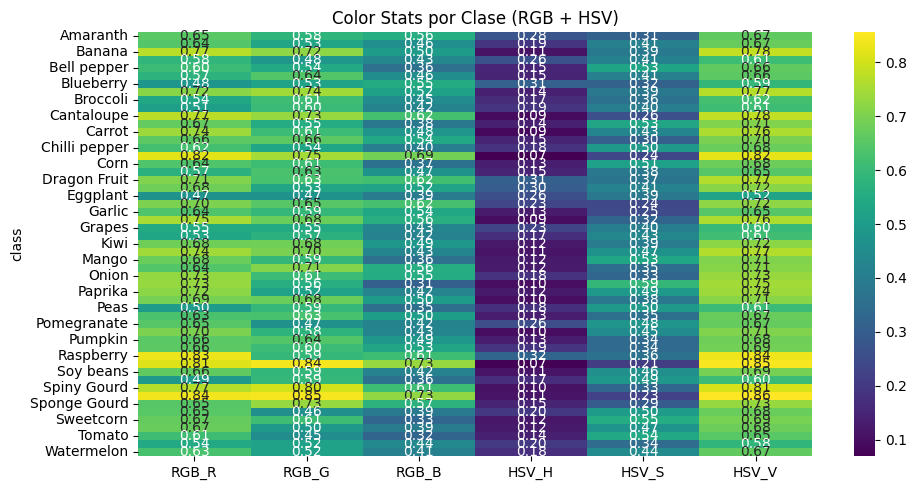

In [48]:
# Visualización de estadísticas de color
plt.figure(figsize=(10,5))

subset = color_stats.set_index("class")[["RGB_R","RGB_G","RGB_B","HSV_H","HSV_S","HSV_V"]]

sns.heatmap(subset, annot=True, cmap="viridis", fmt=".2f")
plt.title("Color Stats por Clase (RGB + HSV)")
plt.tight_layout()
plt.savefig(BASE_DIR / 'outputs/figures/color_stats_heatmap.png')
plt.show()



/tmp/ipykernel_909336/4238167534.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


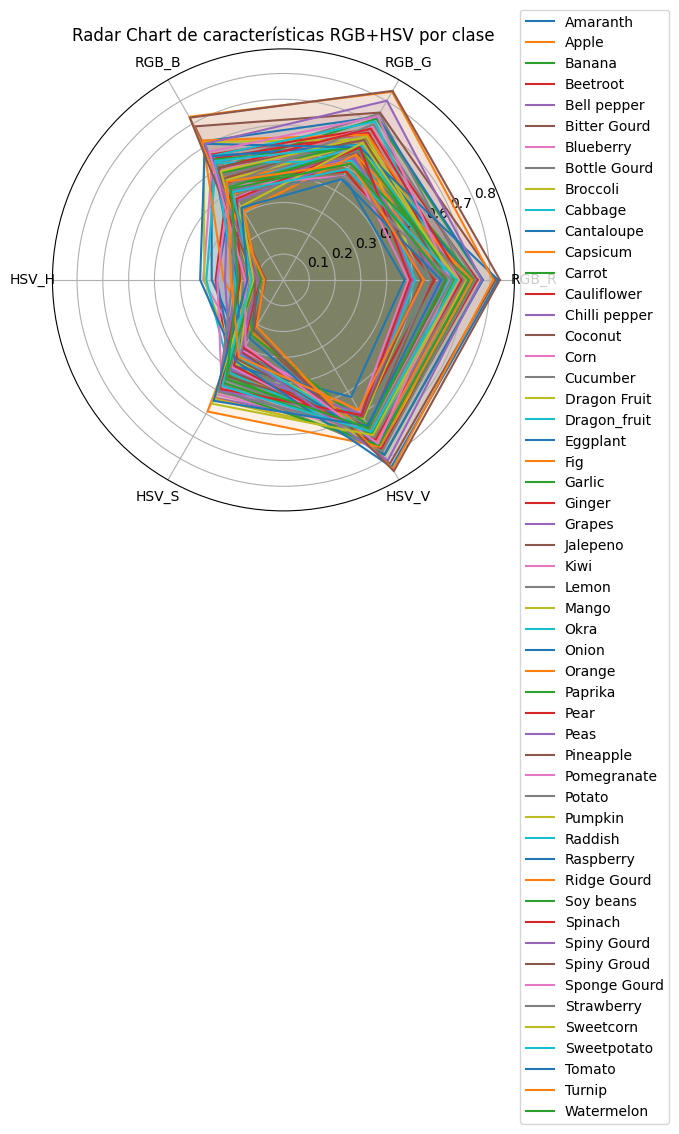

In [47]:
# Radar Chart de estadísticas de color por clase
from math import pi

features = ["RGB_R","RGB_G","RGB_B","HSV_H","HSV_S","HSV_V"]
num_vars = len(features)

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # cerrar círculo

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

for _, row in color_stats.iterrows():
    values = row[features].tolist()
    values += values[:1]  # cerrar gráfico
    ax.plot(angles, values, label=row["class"])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
plt.title("Radar Chart de características RGB+HSV por clase")
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1))
plt.tight_layout()
plt.savefig(BASE_DIR / 'outputs/figures/radar_chart_color_stats.png')
plt.show()


1. RGB (promedio por clase)

   - Rango de R: 0.469 (Eggplant) – 0.839 (Spiny Groud)
   - Rango de G: 0.451 (Tomato) – 0.846 (Spiny Groud)
   - Rango de B: 0.307 (Orange) – 0.730 (Ridge Gourd)
   - Clases con colores muy saturados: Spiny Groud, Ridge Gourd, Raspberry, Dragon Fruit → R/B altos.
   - Clases más “oscuras” o menos saturadas: Eggplant, Tomato, Sweetpotato → valores RGB bajos.

2. HSV (promedio por clase)

   - H (tono): 0.069 (Coconut) – 0.323 (Raspberry)
      - La mayoría de las frutas/vegetales se concentran entre 0.09–0.25.
      - Algunos outliers como Raspberry y Dragon Fruit con tonos más rojizos/rosados.
   - S (saturación): 0.208 (Ridge Gourd) – 0.589 (Orange)
      - Los vegetales verdes tienden a saturaciones menores (Spinach, Broccoli).
      - Frutas cítricas y coloridas (Orange, Bell pepper) muestran saturación alta.
   - V (valor/brillo): 0.524 (Eggplant) – 0.856 (Spiny Groud)
      - Verduras oscuras y raíces como Eggplant, Beetroot tienen menor brillo.
      - Frutas brillantes o claras (Spiny Groud, Raspberry, Coconut) destacan en V.

3. Desviaciones estándar

   - Las desviaciones estándar en RGB/HSV muestran variabilidad moderada, indicando que dentro de cada clase hay cierta diversidad de iluminación y color.
   - Clases como Spiny Groud, Paprika, Raspberry muestran std más alto → podrían requerir data augmentation para estabilizar el aprendizaje.

### Conclusiones 

1. RGB uniforme:
   - La mayoría de las imágenes están en RGB.

2. Diversidad de colores por clase:

   - Hay clases claramente diferenciables por color (ej: Raspberry, Eggplant, Orange).
   - Algunas clases podrían ser más cercanas entre sí en color (ej: Cabbage vs Broccoli) → usar redes que combinen color y textura.

3. Variabilidad interna:

   - Algunas clases tienen mucha variabilidad interna de color/brillo → recomendable data augmentation, especialmente para entrenar modelos robustos.

4. Uso de HSV:
  
   - Los valores de H y S permiten identificar clusters de color dominantes → útil para análisis de preprocesamiento o para filtrar outliers.

5. Tamaño y brillo:
  
   - Los valores de V reflejan la luminosidad promedio de la clase. Esto puede ayudar a normalizar imágenes o ajustar el contraste si se observa que algunas clases son muy oscuras.

### 1.7 Chequeo simple de “fondo blanco” (sesgo)

In [49]:
### 1.7 Chequeo simple de “fondo blanco” (sesgo)
def white_background_ratio(img_pil, v_thresh=0.92, s_thresh=0.2):
    """
    Calcula el porcentaje de píxeles que podrían corresponder a un fondo blanco.
    - V: brillo
    - S: saturación
    """
    arr = np.array(img_pil.convert("RGB"))
    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV).astype(np.float32)/255.0
    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    mask = (V >= v_thresh) & (S <= s_thresh)
    return mask.mean()

bg_rows = []
for cls in summary["class"]:
    paths = df_train[df_train["class"]==cls]["path"].tolist()
    # tomar hasta 150 imágenes para velocidad
    paths = random.sample(paths, k=min(150, len(paths)))
    ratios = [white_background_ratio(load_image(p)) for p in paths]
    bg_rows.append({
        "class": cls,
        "bg_white_ratio_mean": np.mean(ratios),
        "bg_white_ratio_std": np.std(ratios)
    })

bg_df = pd.DataFrame(bg_rows)
bg_df = bg_df.sort_values("bg_white_ratio_mean", ascending=False).round(3)

print(bg_df)



/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


            class  bg_white_ratio_mean  bg_white_ratio_std
40    Ridge Gourd                0.620               0.177
15        Coconut                0.456               0.273
43    Spiny Gourd                0.455               0.316
39      Raspberry                0.454               0.293
20            Fig                0.379               0.322
28           Okra                0.375               0.362
44   Sponge Gourd                0.366               0.242
10     Cantaloupe                0.363               0.271
0        Amaranth                0.345               0.180
32           Pear                0.338               0.312
2          Banana                0.325               0.286
29          Onion                0.321               0.267
12         Carrot                0.306               0.366
38        Raddish                0.301               0.316
22         Ginger                0.296               0.278
25           Kiwi                0.290               0.2

Chequeo de fondo blanco (bg_white_ratio_mean)

 - Rango de valores: va desde ~0.09 (Tomato) hasta ~0.62 (Ridge Gourd).

Interpretación:

 - Clases como Ridge Gourd, Coconut, Spiny Gourd, Raspberry tienen un porcentaje relativamente alto de fondo blanco → muchas imágenes sobre fondo claro.
 - Clases como Tomato, Eggplant, Corn, Peas tienen muy poco fondo blanco → fotos más naturales o con fondo más variado.
 - Desviación estándar: algunas clases tienen un std alto (~0.3), lo que indica alta variabilidad: no todas las imágenes están sobre fondo blanco, aunque algunas sí.

Conclusión:

 - Hay un sesgo de fondo blanco parcial en varias clases. Esto puede afectar a un modelo si aprende a asociar el fondo con la clase en lugar de la fruta/verdura misma.
 - Clases con bajo ratio (~0.1–0.2) parecen más “naturales” o variadas en contexto.

### 1.8 Duplicados / casi-duplicados con perceptual hash

In [51]:
import imagehash
from tqdm import tqdm

# Parámetros
SEED = 42
MAX_HASH = 2527

# Tomamos una muestra de df_train
sample_df = df_train.sample(n=min(MAX_HASH, len(df_train)), random_state=SEED).reset_index(drop=True)

# Calculamos el perceptual hash
hashes = []
for p in tqdm(sample_df["path"], desc="Hashing"):
    img = load_image(p).resize((256, 256))
    h = imagehash.phash(img)   # perceptual hash
    hashes.append(str(h))

sample_df["phash"] = hashes

# Detectar duplicados
dup_groups = sample_df.groupby("phash").filter(lambda g: len(g) > 1).sort_values("phash")

# Mostrar los primeros 10 duplicados
dup_groups.head(10)


Hashing:  16%|█▌        | 396/2527 [00:05<00:17, 124.01it/s]/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Hashing: 100%|██████████| 2527/2527 [00:29<00:00, 86.84it/s] 


,path,class,split,phash
1048,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Orange,train,80d05f077a8f789e
1609,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Orange,train,80d05f077a8f789e
2092,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Carrot,train,8143739c1f5a6537
359,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Carrot,train,8143739c1f5a6537
1634,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Peas,train,81cbbcb4493972cd
1824,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Peas,train,81cbbcb4493972cd
209,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Soy beans,train,838fae368cd6705a
1118,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Soy beans,train,838fae368cd6705a
25,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Lemon,train,861e6ae0392f71e5
1866,/home/martin/Documents/CEIA/CEIA-VPC3/data/raw...,Lemon,train,861e6ae0392f71e5


Detección de duplicados vía phash

  - Se detectaron imágenes duplicadas exactas o muy similares:
    - Ejemplo: Orange tiene 2 imágenes idénticas (80d05f077a8f789e).
    - Otros duplicados: Carrot, Peas, Soy beans, Lemon.
  - Estos duplicados están todas en el split de train, lo que puede inflar artificialmente el rendimiento de un modelo si no se controla.

Conclusión:

  - Elimiar imagenes duplicadas, Algunos duplicados no son obvios visualmente y solo el hash perceptual los detecta. 

### 1.9 Embeddings con ResNet18 preentrenado + UMAP

Se busca visualizar la separabilidad de las clases en un espacio de características extraído por una red neuronal ya entrenada en un dataset grande (ImageNet).

In [3]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")

CUDA available: False
CUDA device count: 1


Embeddings:  58%|█████▊    | 822/1428 [00:12<00:06, 91.36it/s] /home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Embeddings: 100%|██████████| 1428/1428 [00:21<00:00, 65.92it/s] 
/tmp/ipykernel_909336/2308338321.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


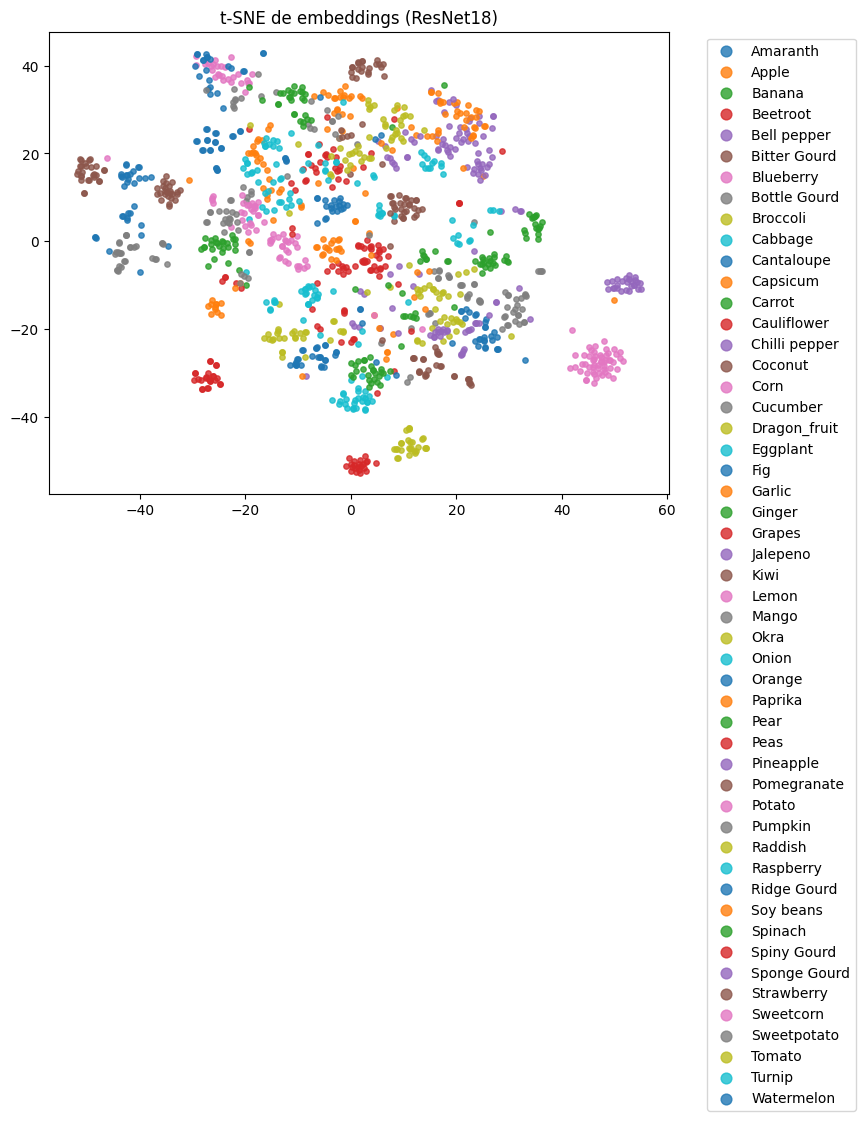

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# --- Config ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Modelo ResNet18 preentrenado ---
weights = models.ResNet18_Weights.IMAGENET1K_V1
resnet = models.resnet18(weights=weights)
resnet.fc = nn.Identity()  # usar penúltima capa como embedding
resnet = resnet.to(device).eval()

# Transform oficial asociado a los pesos
transform = weights.transforms()

# --- Submuestreo balanceado por clase sobre df_train ---
per_cls = min(120, df_train["class"].value_counts().min())
emb_samples = []
for cls in summary["class"]:
    paths_cls = df_train[df_train["class"] == cls]["path"]
    if len(paths_cls) == 0:
        continue
    paths = paths_cls.sample(n=min(per_cls, len(paths_cls)), random_state=SEED).tolist()
    for p in paths:
        emb_samples.append((p, cls))

# --- Extracción de embeddings ---
EMBS, LABELS = [], []
with torch.no_grad():
    for p, cls in tqdm(emb_samples, desc="Embeddings"):
        img = load_image(p, to_rgb=True)  # asegura RGB
        x = transform(img).unsqueeze(0).to(device)
        feat = resnet(x).cpu().numpy().squeeze()
        EMBS.append(feat)
        LABELS.append(cls)

EMBS = np.array(EMBS)

# --- Reducción de dimensionalidad ---
try:
    from umap.umap_ import UMAP
    reducer = UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
    method = "UMAP"
except ImportError:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, perplexity=30, random_state=SEED)
    method = "t-SNE"

Z = reducer.fit_transform(EMBS)

# --- Plot ---
plt.figure(figsize=(8, 6))
for cls in summary["class"]:
    idx = [i for i, l in enumerate(LABELS) if l == cls]
    if len(idx) == 0:
        continue
    plt.scatter(Z[idx, 0], Z[idx, 1], s=15, alpha=0.8, label=cls)
plt.title(f"{method} de embeddings (ResNet18)")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(BASE_DIR / 'outputs/figures/embeddings_umap_resnet18.png')
plt.show()


In [65]:
import numpy as np


import os
import pandas as pd

np.set_printoptions(threshold=np.inf)  # disable truncation

BASE_PATH = "/home/martin/Documents/CEIA/CEIA-VPC3/data/raw"  # adjust to your dataset root

# Create relative paths
paths = [os.path.relpath(p, BASE_PATH) for p, cls in emb_samples]

# Create DataFrame with embeddings + class + relative path
df_emb = pd.DataFrame({
    "x": Z[:, 0],
    "y": Z[:, 1],
    "class": LABELS,
    "path": paths
})

# Quick check
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(df_emb)
df_emb.to_csv("embeddings_2D_relative.csv", index=False)


              x          y          class  \
0     -6.322430 -24.018196       Amaranth   
1     -5.893723 -26.394266       Amaranth   
2     -6.630839 -24.276733       Amaranth   
3    -10.623429 -27.900459       Amaranth   
4    -11.524698 -28.154041       Amaranth   
5     -5.570190 -28.576788       Amaranth   
6     -4.838559 -23.719275       Amaranth   
7     -2.991237 -25.906630       Amaranth   
8     19.133293 -23.229313       Amaranth   
9     -7.321565 -26.140760       Amaranth   
10    -4.838410 -23.718813       Amaranth   
11    -9.360341 -28.290165       Amaranth   
12   -10.403022 -28.257860       Amaranth   
13    -6.663826 -24.350142       Amaranth   
14    -9.170742 -24.720808       Amaranth   
15    -9.935257 -26.790459       Amaranth   
16   -10.338968 -28.337416       Amaranth   
17   -10.475313 -27.508572       Amaranth   
18    -6.156127 -26.351727       Amaranth   
19    -2.842275 -25.292862       Amaranth   
20   -10.116460 -26.889984       Amaranth   
21    -5.5

# Resumen de Hallazgos: Embeddings 2D + Estadísticas de Color

## 1. Calidad General del Clustering (Embeddings 2D)
- **Silhouette Score**: 0.063 → separación moderada/baja en proyección 2D.
- **Método**: UMAP (o t-SNE si no disponible).
- **Observación**: Los embeddings de 512D (ResNet18) separan mejor que la proyección 2D.

---

## 2. Agrupamiento Semántico en el Espacio 2D

| Región | Clases Principales | Características Visuales |
|--------|---------------------|---------------------------|
| **X+, Y-** | Calabazas (Bitter Gourd, Bottle Gourd, Ridge Gourd, Sponge Gourd), Pepino, Okra | Elongadas, verdes/amarillas, fondo blanco alto |
| **X++, Y--** | Maíz, Maíz Dulce | Amarillo intenso, granos expuestos |
| **X-, Y+** | Cítricos (Limón, Naranja), Manzana, Pera, Tomate | Redondos, colores vibrantes |
| **X--, Y+** | Coco, Cantalupo, Calabaza | Grandes, pálidos o anaranjados |
| **X-, Y--** | Hojas (Amaranto, Espinaca), Fruta del Dragón | Verdes oscuros o rosados |

---

## 3. Compactación por Clase (Dispersión en 2D)

| Compactas (baja dispersión < 2.5) | Dispersas (alta > 13) |
|-----------------------------------|------------------------|
| Fresa (1.67), Coco (1.78), Brócoli (1.83), Repollo (1.95) | Pimentón (21.29), Naranja (14.80), Sandía (13.71), Rábano (13.69) |

> **Conclusión**: Clases con imágenes uniformes → clústeres apretados.

---

## 4. Estadísticas de Color (RGB/HSV)

### Agrupamientos por Tono (HSV_H)
| Grupo | Clases | Tono (H) | Saturación (S) | Valor (V) |
|------|--------|---------|----------------|-----------|
| **Amarillo-Verde (Gourds)** | Ridge Gourd, Spiny Gourd, Bottle Gourd | 0.07–0.15 | 0.21–0.41 | 0.73–0.85 |
| **Amarillo-Naranja (Frutas)** | Plátano, Melón, Limón, Naranja, Mango | 0.08–0.12 | 0.26–0.59 | 0.70–0.78 |
| **Rojo/Rosa** | Fresa, Tomate, Granada, Frambuesa | 0.14–0.32 | 0.37–0.54 | 0.65–0.84 |
| **Verde (Hojas/Pods)** | Espinaca, Repollo, Brócoli, Chícharos | 0.16–0.19 | 0.36–0.53 | 0.60–0.67 |
| **Morado/Azul** | Berenjena, Arándano, Uvas | 0.23–0.31 | 0.32–0.42 | 0.52–0.72 |

---

## 5. Influencia del Fondo Blanco

| Grupo | Clases | Ratio Blanco (Media) | Std | Interpretación |
|-------|--------|------------------------|-----|----------------|
| **Fondo Limpio** | Ridge Gourd, Coco, Spiny Gourd | 0.36–0.62 | 0.18–0.32 | Fotos de estudio → embeddings puros |
| **Fondo Mixto/Natural** | Tomate, Maíz Dulce, Chícharos | 0.09–0.14 | 0.17–0.23 | Mercado/exterior → ruido de fondo |

> **Correlación**: Alto fondo blanco → baja dispersión en 2D.

---

## 6. Variabilidad de Color (Std Dev)

| Mayor Variabilidad | Menor Variabilidad |
|--------------------|---------------------|
| Pimentón (RGB std alto), Frambuesa (H std 0.287) | Repollo (H std 0.074), Maíz Dulce (H std 0.076) |

> **Insight**: Variabilidad de color → mayor dispersión en embeddings 2D.

---

## 7. Anomalías en los Datos

| Clase | Problema | Evidencia |
|------|---------|-----------|
| `Dragon Fruit` / `Dragon_fruit` | Duplicado | Estadísticas ligeramente distintas |
| `Spiny Gourd` / `Spiny Groud` | Error tipográfico | Mismo concepto |
| `Corn` vs `Sweetcorn` | Casi idénticos | Distancia centroides: 0.67 |
| `Paprika` | Alta dispersión | Std RGB alto + fondo mixto |

---

## 8. Recomendaciones

```python
# 1. Unificar duplicados
df['class'] = df['class'].replace({
    'Dragon_fruit': 'Dragon Fruit',
    'Spiny Groud': 'Spiny Gourd',
    'Sweetcorn': 'Corn'
})

# 2. Filtrar clases con fondo limpio
clean_classes = df[df['bg_white_ratio_mean'] > 0.3]['class'].unique()

# 3. Aumentar embeddings con color
EMBS_aug = np.hstack([EMBS, color_means[['RGB_R','RGB_G','RGB_B']].values])

In [67]:
# --- Métricas de clusterización ---

# Calcular métricas sobre los embeddings (usando las etiquetas reales)
silhouette = silhouette_score(EMBS, LABELS, metric="euclidean")
db_index = davies_bouldin_score(EMBS, LABELS)
ch_index = calinski_harabasz_score(EMBS, LABELS)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Calinski-Harabasz Index: {ch_index:.3f}")

Silhouette Score: 0.057
Davies-Bouldin Index: 3.195
Calinski-Harabasz Index: 18.286


### 1.10 Baseline rápido: histograma de color + Logistic Regression

/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.413
Macro-F1: 0.38
               precision    recall  f1-score   support

     Amaranth      0.667     1.000     0.800        10
        Apple      0.000     0.000     0.000        10
       Banana      0.333     0.444     0.381         9
     Beetroot      0.429     0.300     0.353        10
  Bell pepper      0.000     0.000     0.000         9
 Bitter Gourd      0.500     0.273     0.353        11
    Blueberry      0.571     1.000     0.727         8
 Bottle Gourd      0.667     0.632     0.649        19
     Broccoli      0.421     0.471     0.444        17
      Cabbage      0.778     0.700     0.737        10
   Cantaloupe      0.625     0.833     0.714         6
     Capsicum      0.500     0.300     0.375        10
       Carrot      0.462     0.667     0.545         9
  Cauliflower      0.286     0.400     0.333        10
Chilli pepper      0.000     0.000     0.000         9
      Coconut      0.667     1.000     0.800         6
         Corn      0.667     0.20

/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

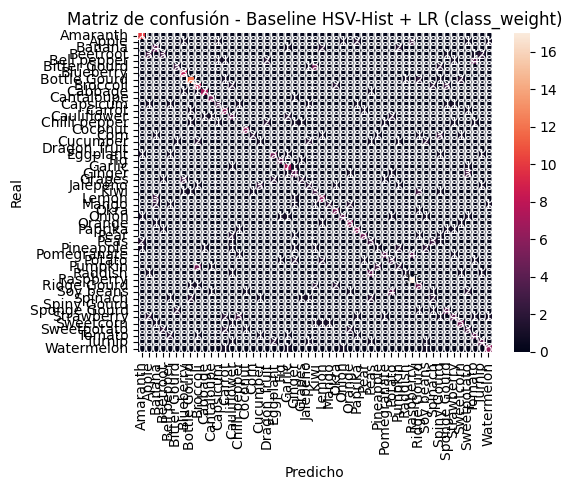

In [ ]:
# --- Histograma en HSV con opción de "ignorar fondo blanco" ---
def color_hist_features(path, bins_h=16, bins_s=8, bins_v=8,
                        ignore_white_bg=True, v_thresh=0.92, s_thresh=0.20):
    img = load_image(path, to_rgb=True)
    arr = np.array(img).astype(np.uint8)
    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV)

    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

    if ignore_white_bg:
        mask = ~((V >= int(v_thresh*255)) & (S <= int(s_thresh*255)))
        H, S, V = H[mask], S[mask], V[mask]
        # si la máscara borra demasiado, volvemos al total
        if H.size < 100:  
            H, S, V = hsv[:,:,0].ravel(), hsv[:,:,1].ravel(), hsv[:,:,2].ravel()

    h_hist, _ = np.histogram(H, bins=bins_h, range=(0,255), density=True)
    s_hist, _ = np.histogram(S, bins=bins_s, range=(0,255), density=True)
    v_hist, _ = np.histogram(V, bins=bins_v, range=(0,255), density=True)

    return np.concatenate([h_hist, s_hist, v_hist], axis=0)  # 16+8+8 = 32 feats

# --- Features for train and val separately ---
X_train = np.vstack([color_hist_features(p) for p in df_train["path"]])
y_train = df_train["class"].values

X_val = np.vstack([color_hist_features(p) for p in df_val["path"]])
y_val = df_val["class"].values

# --- Pesos de clase para train ---
classes = np.unique(y_train)
cls_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
weight_dict = {c:w for c, w in zip(classes, cls_weights)}

# --- Pipeline: estandarizar + LR multinomial con class_weight ---
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=3000, multi_class="multinomial",
                       class_weight=weight_dict, random_state=SEED)
)
clf.fit(X_train, y_train)

# --- Evaluación sobre val ---
y_pred = clf.predict(X_val)
print("Accuracy:", (y_pred == y_val).mean().round(3))
print("Macro-F1:", round(f1_score(y_val, y_pred, average="macro"), 3))
print(classification_report(y_val, y_pred, digits=3))

cm = confusion_matrix(y_val, y_pred, labels=summary["class"].tolist())



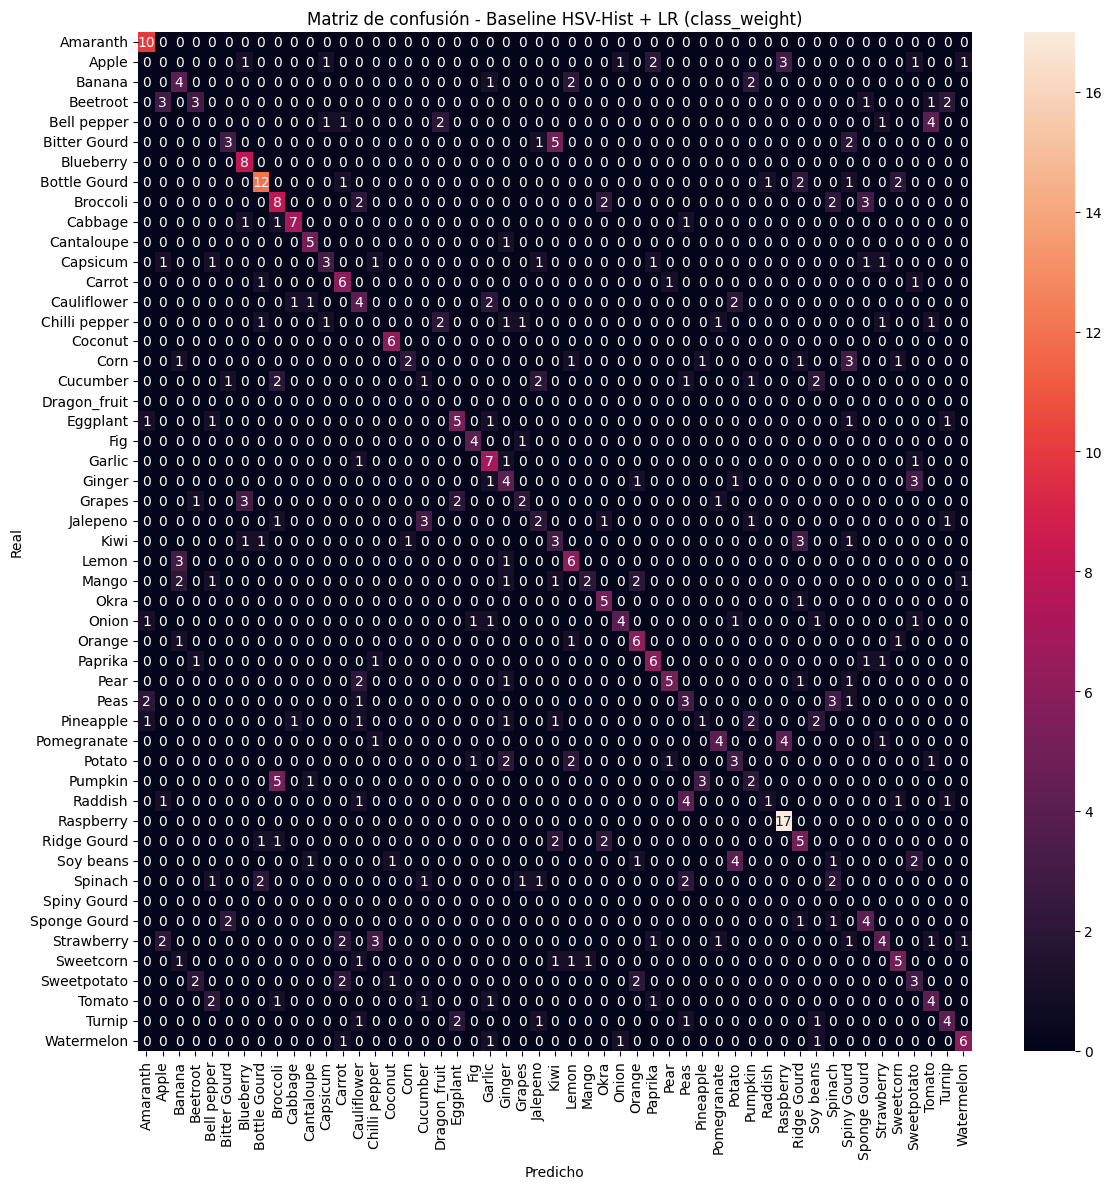

In [71]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=summary["class"], yticklabels=summary["class"])
plt.title("Matriz de confusión - Baseline HSV-Hist + LR (class_weight)")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.savefig(BASE_DIR / 'outputs/figures/confusion_matrix_hsv_hist_lr.png')
plt.tight_layout(); plt.show()

In [74]:
from sklearn.metrics import precision_recall_fscore_support

# --- Métricas por clase sobre val ---
prec, rec, f1, support = precision_recall_fscore_support(
    y_val, y_pred, labels=summary["class"].tolist()
)

metrics_df = pd.DataFrame({
    "class": summary["class"].tolist(),
    "precision": prec,
    "recall": rec,
    "f1-score": f1,
    "support": support
})

display(metrics_df)

# --- Plot comparativo ---



/home/martin/Documents/CEIA/CEIA-VPC3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,class,precision,recall,f1-score,support
0,Amaranth,0.666667,1.000000,0.800000,10
1,Apple,0.000000,0.000000,0.000000,10
2,Banana,0.333333,0.444444,0.380952,9
3,Beetroot,0.428571,0.300000,0.352941,10
4,Bell pepper,0.000000,0.000000,0.000000,9
5,Bitter Gourd,0.500000,0.272727,0.352941,11
6,Blueberry,0.571429,1.000000,0.727273,8
7,Bottle Gourd,0.666667,0.631579,0.648649,19
8,Broccoli,0.421053,0.470588,0.444444,17
9,Cabbage,0.777778,0.700000,0.736842,10


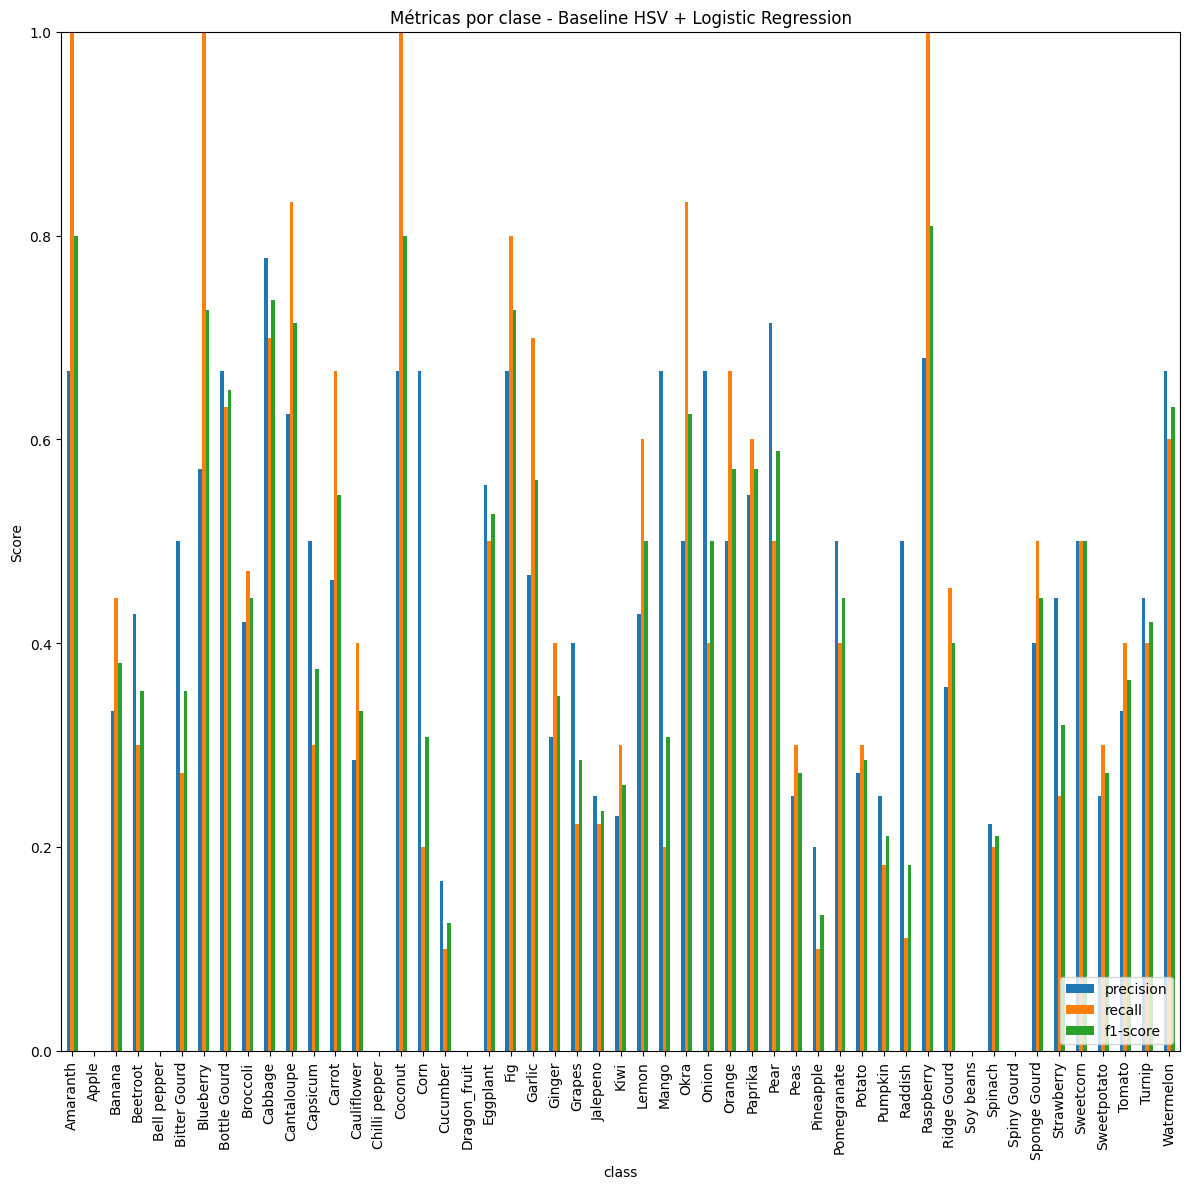

In [77]:
fig, ax = plt.subplots(figsize=(12,12))

metrics_df.set_index("class")[["precision","recall","f1-score"]].plot(
    kind="bar",
    rot=0,
    ax=ax      
)

ax.set_title("Métricas por clase - Baseline HSV + Logistic Regression")
ax.set_ylabel("Score")
ax.set_ylim(0,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.legend(loc="lower right")

plt.tight_layout()
plt.show()
